## Time series analysis of temperature in Berlin (Germany)
#### 30th of Mai 2022

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa import stattools
import warnings
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Ignore warnings
warnings.filterwarnings("ignore")

In [3]:
# get data
data = pd.read_csv("TG_STAID002759.txt", header=14, sep=",", skipinitialspace=True)
df = pd.DataFrame(data)

In [4]:
# transform column "DATE" into datetime format and use it as index
df["DATE"]=pd.to_datetime(df["DATE"], format="%Y%m%d")
gap_start = df["DATE"][df["Q_TG"]==9].min()
gap_end = df["DATE"][df["Q_TG"]==9].max()
df.drop(df[df["Q_TG"]==9].index, inplace=True)				# rows with Q_TG=9 are missing values
df["timestep"] = range(len(df["DATE"]))
df = df.set_index("DATE")

In [5]:
# 1945 is a big data gap. For a better model only data from 1946 onwards will be used
df_wo_gap = df[df["timestep"][df.index.year==1946].min():-365]

In [6]:
# Create test data (last year of dataset)
df_test = df[-365:]
df_test["TG"] = df_test["TG"] / 10				# TG values are given in 0.1°C

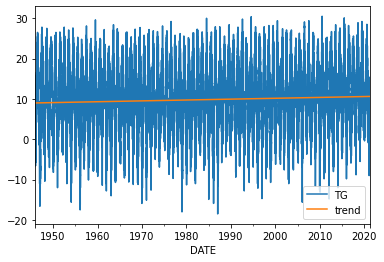

In [7]:
# Create trendline for TG
X = df_wo_gap[["timestep"]]
df_wo_gap["TG"] = df_wo_gap["TG"]/10			# TG values are given in 0.1°C
y = df_wo_gap["TG"]				
linear = LinearRegression()
linear.fit(X, y)
df_wo_gap["trend"] = linear.predict(X)
df_wo_gap[["TG", "trend"]].plot()
plt.show()

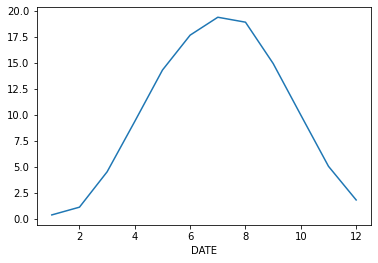

In [8]:
# Data engineering: add one column for each month (OneHotEncoding bascially)
seasonal_dummies = pd.get_dummies(df_wo_gap.index.month, drop_first=True, prefix='month').set_index(df_wo_gap.index)
df_wo_gap = df_wo_gap.join(seasonal_dummies)
df_wo_gap.groupby(df_wo_gap.index.month)['TG'].mean().plot()
plt.show()

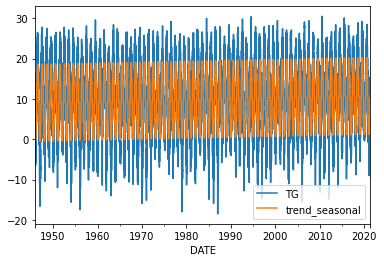

In [9]:
# Create seasonal trendline
X_season = df_wo_gap.drop(["SOUID", "Q_TG", "trend", "TG"], axis=1)
linear.fit(X_season, y)
df_wo_gap["trend_seasonal"] = linear.predict(X_season)
df_wo_gap[["TG", "trend_seasonal"]].plot()
plt.show()

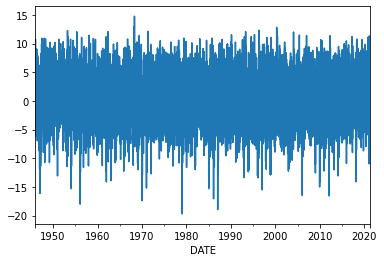

In [10]:
# Calculate the remainder of TG
df_wo_gap['remainder'] = df_wo_gap['TG'] - df_wo_gap['trend_seasonal']
df_wo_gap["remainder"].plot()
plt.show()
df_wo_gap['remainder'].to_csv('temperature_remainder.csv')

In [12]:
# Check for stationarity of the data
print("Check for stationarity of the remainder data:", statsmodels.tsa.stattools.adfuller(df_wo_gap["remainder"]))

Check for stationarity of the remainder data: (-23.392011351181228, 0.0, 31, 27482, {'1%': -3.4305879707046416, '5%': -2.861645176265101, '10%': -2.5668259821778747}, 123998.29313377195)


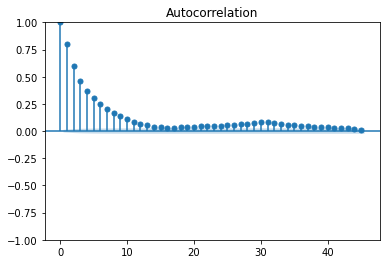

In [13]:
# Check for the number of relevant lags
# A.1: Autocorrelation Function 
plot_acf(df_wo_gap["remainder"])
plt.show()

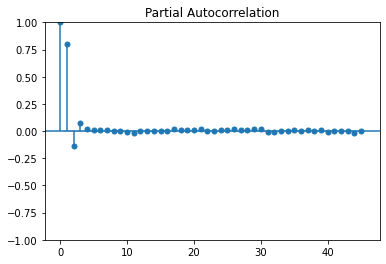

In [15]:
# A.2: Partial Autocorrelation Function
plot_pacf(df_wo_gap['remainder'])
plt.show()

In [16]:
# B: Statsmodels functionality
selected_order = ar_select_order(df_wo_gap['remainder'], maxlag=12)
print(selected_order.bic)

{(1, 2, 3): 124227.68336906124, (1, 2, 3, 4): 124227.77549824331, (1, 2, 3, 4, 5): 124236.57956915937, (1, 2, 3, 4, 5, 6): 124245.0821515929, (1, 2, 3, 4, 5, 6, 7): 124253.90906643751, (1, 2, 3, 4, 5, 6, 7, 8): 124263.50437954898, (1, 2, 3, 4, 5, 6, 7, 8, 9): 124273.6735120088, (1, 2, 3, 4, 5, 6, 7, 8, 9, 10): 124283.21020709306, (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11): 124288.37198194566, (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12): 124298.31542033715, (1, 2): 124370.20276972697, (1,): 124887.48343627741, 0: 153613.49683190338}


In [17]:
# Add the first four lags to df_wo_gap
df_wo_gap["lag1"] = df_wo_gap["remainder"].shift(1)
df_wo_gap["lag2"] = df_wo_gap["remainder"].shift(2)
df_wo_gap["lag3"] = df_wo_gap["remainder"].shift(3)
df_wo_gap["lag4"] = df_wo_gap["remainder"].shift(4)
df_wo_gap.dropna(inplace=True)

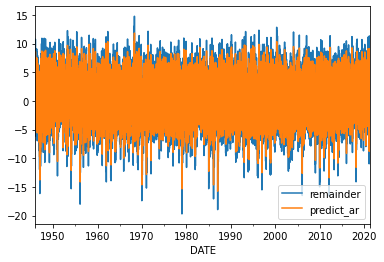

In [18]:
# Predict reminder using autoregression
ar_model = AutoReg(endog=df_wo_gap["remainder"], lags=4).fit()
df_wo_gap["predict_ar"] = ar_model.predict()
df_wo_gap[["remainder", "predict_ar"]].plot()
plt.show()

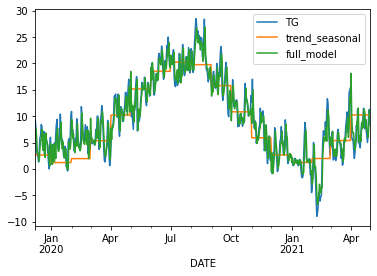

In [19]:
# Predict TG based on month, lag1-4 and timestep
X_full = df_wo_gap.drop(["SOUID", "Q_TG", "trend", "TG", "trend_seasonal", "remainder", "predict_ar"], axis=1)
y = df_wo_gap["TG"]
linear_full = LinearRegression()
linear_full.fit(X_full, y)
df_wo_gap["full_model"] = linear_full.predict(X_full)
df_wo_gap[27000:][['TG', 'trend_seasonal', 'full_model']].plot()
plt.show()

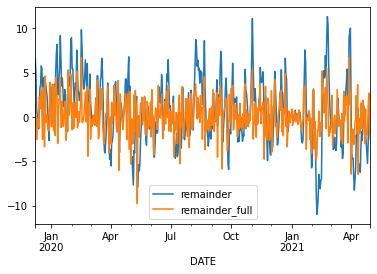

In [20]:
# Calculate the new remainder
df_wo_gap["remainder_full"] = df_wo_gap["TG"] - df_wo_gap["full_model"]
df_wo_gap[27000:][["remainder", "remainder_full"]].plot()
plt.show()

In [21]:
# Cross validation of training data
ts_split = TimeSeriesSplit(n_splits=5)			# Data will be split in 5 ~equally sized parts
time_series_split = ts_split.split(X_full, y)
result = cross_val_score(estimator=linear_full, X=X_full, y=y, cv=time_series_split)
print(result)

[0.91521312 0.91003729 0.90633833 0.91533327 0.92045246]


In [22]:
### Evaluation using test data
# Create seasonal dummies
seasonal_dummies_test = pd.get_dummies(df_test.index.month, drop_first=True, prefix='month').set_index(df_test.index)
df_test = df_test.join(seasonal_dummies_test)

In [23]:
# Assign the X_test variable
X_test = df_test.drop(["SOUID", "Q_TG", "TG"], axis =1)

<AxesSubplot:xlabel='DATE'>

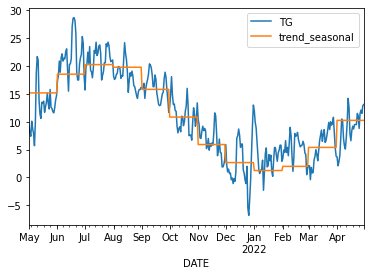

In [24]:
# Create seasonal_trend_test
df_test["trend_seasonal"] = linear.predict(X_test)
df_test[["TG", "trend_seasonal"]].plot()

In [25]:
# Calculate the remainder_test
df_test["remainder"] = df_test["TG"] - df_test["trend_seasonal"]

In [26]:
# Add lags to test data
df_test["lag1"] = df_test["remainder"].shift(1)
df_test["lag2"] = df_test["remainder"].shift(2)
df_test["lag3"] = df_test["remainder"].shift(3)
df_test["lag4"] = df_test["remainder"].shift(4)

In [27]:
# Add lags of first days from remainder of train data
df_test.loc["2021-05-01", "lag1"] = df_wo_gap.loc["2021-04-30", "remainder_full"]
df_test.loc["2021-05-01", "lag2"] = df_wo_gap.loc["2021-04-29", "remainder_full"]
df_test.loc["2021-05-01", "lag3"] = df_wo_gap.loc["2021-04-28", "remainder_full"]
df_test.loc["2021-05-01", "lag4"] = df_wo_gap.loc["2021-04-27", "remainder_full"]
df_test.loc["2021-05-02", "lag2"] = df_wo_gap.loc["2021-04-30", "remainder_full"]
df_test.loc["2021-05-02", "lag3"] = df_wo_gap.loc["2021-04-29", "remainder_full"]
df_test.loc["2021-05-02", "lag4"] = df_wo_gap.loc["2021-04-28", "remainder_full"]
df_test.loc["2021-05-03", "lag3"] = df_wo_gap.loc["2021-04-30", "remainder_full"]
df_test.loc["2021-05-03", "lag4"] = df_wo_gap.loc["2021-04-29", "remainder_full"]
df_test.loc["2021-05-04", "lag4"] = df_wo_gap.loc["2021-04-30", "remainder_full"]

In [28]:
# Predict the temperature of the test data (last year)
X_test_full = df_test.drop(["SOUID", "TG", "Q_TG", "trend_seasonal", "remainder"], axis=1)
df_test["full_model"] = linear_full.predict(X_test_full)

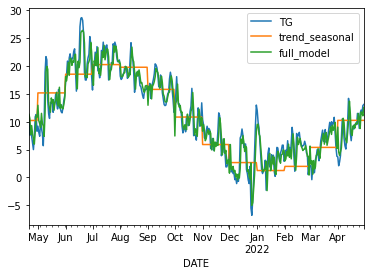

In [29]:
# Combine train and test again to evaluate the model
df_full = df_wo_gap[["TG", "trend_seasonal", "full_model"]].append(df_test[["TG", "trend_seasonal", "full_model"]])
df_full[27500:].plot()
plt.show()

In [30]:
# Calculate the score of the model regarding the test data 
print("The score of the full_model is:", round(linear_full.score(X_test_full, df_test['TG']), 3))

The score of the full_model is: 0.92


In [31]:
### Predicting future temperatures
# Combine complete train and test datasets
df_complete = df_wo_gap.append(df_test)

In [32]:
# Train model with complete dataset
X_compl = df_complete.drop(["SOUID", "Q_TG", "TG", "trend", "remainder", "full_model", "trend_seasonal", "predict_ar", "remainder_full"], axis=1)
y_compl = df_complete["TG"]
linear_compl = LinearRegression()
linear_compl.fit(X_compl, y_compl)

LinearRegression()

In [33]:
# Create components of the future day I predict the temperature on
timestep1 = df_complete["timestep"].max()+1
timestep2 = df_complete["timestep"].max()+2
timestep3 = df_complete["timestep"].max()+3
timestep4 = df_complete["timestep"].max()+4
month = [0]*3 + [1] + [0]*7
lag1 = df_complete.loc["2022-04-30", "remainder"]
lag2 = df_complete.loc["2022-04-29", "remainder"]
lag3 = df_complete.loc["2022-04-28", "remainder"]
lag4 = df_complete.loc["2022-04-27", "remainder"]

In [34]:
# Create future data point1
X_future1 = []
X_future1.append(timestep1)
X_future1.extend(month)
X_future1.append(lag1)
X_future1.append(lag2)
X_future1.append(lag3)
X_future1.append(lag4)
X_future1 = pd.DataFrame([X_future1], columns = X_compl.columns)

In [35]:
# Predict temperature for future data point1
y_future1 = linear_compl.predict(X_future1)

In [36]:
# Create all future data points
X_future2 = []
X_future2.append(timestep2)
X_future2.extend(month)
X_future2.append(lag2)
X_future2.append(lag3)
X_future2.append(lag4)
X_future2.append(0)
X_future2 = pd.DataFrame([X_future2], columns = X_compl.columns)
X_future3 = []
X_future3.append(timestep3)
X_future3.extend(month)
X_future3.append(lag3)
X_future3.append(lag4)
X_future3.append(0)
X_future3.append(0)
X_future3 = pd.DataFrame([X_future3], columns = X_compl.columns)
X_future4 = []
X_future4.append(timestep2)
X_future4.extend(month)
X_future4.append(lag4)
X_future4.append(0)
X_future4.append(0)
X_future4.append(0)
X_future4 = pd.DataFrame([X_future4], columns = X_compl.columns)
y_future2 = linear_compl.predict(X_future2)
y_future3 = linear_compl.predict(X_future3)
y_future4 = linear_compl.predict(X_future4)

In [37]:
# Add predicted temperature to X dataframes
X_future1["TG"] = y_future1
X_future2["TG"] = y_future2
X_future3["TG"] = y_future3
X_future4["TG"] = y_future4

In [38]:
# Add future dataframes to complete dataframe
df_complete = df_complete.append(X_future1)
df_complete = df_complete.append(X_future2)
df_complete = df_complete.append(X_future3)
df_complete = df_complete.append(X_future4)

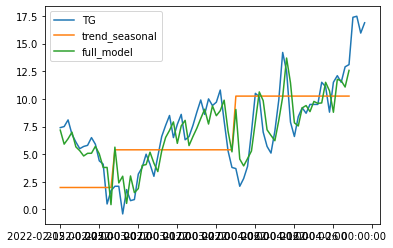

In [39]:
# Plot the future data together with past data
df_complete[27800:][["TG", "trend_seasonal", "full_model"]].plot()
plt.show()

In [40]:
### Using the ARIMA model for prediction
df_ari = df_wo_gap.append(df_test)
df_ari_c = df_ari[["TG", "Q_TG"]]
arima_m = ARIMA(endog=df_ari["TG"], order=(4,0,4)).fit()
df_ari_c["ari_pred"] = arima_m.predict()
df_ari_c.drop(["Q_TG"], axis=1, inplace=True)

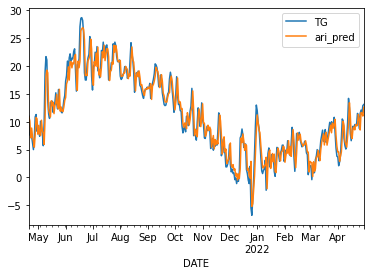

In [41]:
# Plot the ARIMA predictions
df_ari_c[27500:].plot()
plt.show()